# Segmenting and Clustering Neighborhoods in Toronto

In this assignment, we will be scraping postal code data from Wikipedia for the city of Toronto. In part 1, we will wrangle and clean the data. In part 2, we will use the __Foursquare API__ in order to get information about food venues in the city's neighborhoods. Finally, in part 3, we will use a k-means algorithm to cluster the neighborhoods by the most frequent venues, we will visualize the clusters on a map of Toronto, and analyze them to draw conclusions from our findings.

## Part 0 - Load Necessary Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import pgeocode  # get latitude and longitude from a postal code

import requests  # handle requests
from bs4 import BeautifulSoup  # web scraper

from pandas import json_normalize  # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import folium  # map rendering library

## Part 1 - Web Scraping
In this part, we will scrape a Wikipedia page containing a table of Toronto postal codes with their corresponding boroughs and neighborhoods.

Scrape the Wikipedia page using an HTML parser.

In [2]:
url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=862527922'

req = requests.get(url)

soup = BeautifulSoup(req.content, 'html.parser')

Find the table in the HTML, and extract the data in each column. Then create a DataFrame to store all the data.

In [3]:
soup_table = soup.find('table')

# function to get the text from a list of HMTL tags
def get_text_map(lst):
    lst = list(map(lambda s: s.get_text(strip=True), lst))
    
    return lst

# get all the column data
data = soup_table.find_all('td')
data = get_text_map(data)

# get the data for each column
p_codes = data[::3]
bghs = data[1::3]
nbhs = data[2::3]

toronto_df = pd.DataFrame(zip(p_codes, bghs, nbhs), columns=['PostalCode', 'Borough', 'Neighborhood'])
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Filter out all the rows that have value of 'Not assigned' in the __Borough__ column. Also, if a neighborhood has a value of 'Not assigned', replace it with its borough.

In [4]:
# drop rows with no boroughs
toronto_df = toronto_df[toronto_df.Borough != 'Not assigned']

# confirm that there are no boroughs with the value 'Not assigned'
print(toronto_df['Borough'].value_counts())

Etobicoke           45
Scarborough         38
North York          38
Downtown Toronto    37
Central Toronto     17
West Toronto        13
York                 9
East Toronto         7
East York            6
Mississauga          1
Queen's Park         1
Name: Borough, dtype: int64


In [5]:
# replace 'Not assigned' neighborhoods with their boroughs
num_na_before = toronto_df[toronto_df['Neighborhood'] == 'Not assigned'].shape[0]

toronto_df['Neighborhood'] = np.where(toronto_df['Neighborhood'] == 'Not assigned', 
                                      toronto_df['Borough'], 
                                      toronto_df['Neighborhood'])
toronto_df.reset_index(inplace=True, drop=True)

num_na_after = toronto_df[toronto_df['Neighborhood'] == toronto_df['Borough']].shape[0]

# confirm that there are no neighborhoods with the value 'Not assigned'
# and that the count before and after is the same
print("Number of not assigned neighborhoods before:", num_na_before)
print("Number of not assigned neighborhoods after:", num_na_after)
print('\n')

Number of not assigned neighborhoods before: 1
Number of not assigned neighborhoods after: 1




For repeated boroughs, append all neighborhoods and separate them with a comma.

In [6]:
toronto_df = toronto_df.groupby(['PostalCode', 'Borough']).apply(lambda df: ", ".join(df['Neighborhood'])).reset_index(name='Neighborhood')
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Display the table as given by the assignment instructions.

In [7]:
# this is for the purpose of the assignment only
p_codes_lst = ['M5G', 'M2H', 'M4B', 'M1J', 'M4G', 'M4M', 'M1R', 'M9V', 'M9L', 'M5V', 'M1B', 'M5A']
toronto_df[toronto_df['PostalCode'].isin(p_codes_lst)].set_index('PostalCode').loc[p_codes_lst].reset_index()

,PostalCode,Borough,Neighborhood
0,M5G,Downtown Toronto,Central Bay Street
1,M2H,North York,Hillcrest Village
2,M4B,East York,"Woodbine Gardens, Parkview Hill"
3,M1J,Scarborough,Scarborough Village
4,M4G,East York,Leaside
5,M4M,East Toronto,Studio District
6,M1R,Scarborough,"Maryvale, Wexford"
7,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."
8,M9L,North York,Humber Summit
9,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo..."


In [8]:
print("Number of rows in the full table:", toronto_df.shape[0])

Number of rows in the full table: 103


## Part 2 - Getting the Coordinates of Each Neighborhood
In this part we will be using the __pgeocode__ package to get the latitude and longitude values for each postal code.

In [9]:
# get the latitude and longitude of all the postal codes
country = 'CA'  # Canada
nomi = pgeocode.Nominatim(country)
lat_lng_df = nomi.query_postal_code(toronto_df.PostalCode.values)[['postal_code', 'latitude', 'longitude']]
lat_lng_df.drop_duplicates(inplace=True)
lat_lng_df.columns = ['PostalCode', 'Latitude', 'Longitude']

# join the two tables to append the latitude and longitude to our main table
toronto_df = toronto_df.join(lat_lng_df.set_index('PostalCode'), on='PostalCode')
toronto_df.dropna(inplace=True)  # drop rows with NaN latitude and/or longitude
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.8113,-79.1930
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.7878,-79.1564
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.7678,-79.1866
3,M1G,Scarborough,Woburn,43.7712,-79.2144
4,M1H,Scarborough,Cedarbrae,43.7686,-79.2389


Display the table as given by the instructions of the assignment.

In [10]:
toronto_df[toronto_df['PostalCode'].isin(p_codes_lst)].set_index('PostalCode').loc[p_codes_lst].reset_index()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5G,Downtown Toronto,Central Bay Street,43.6564,-79.3860
1,M2H,North York,Hillcrest Village,43.8015,-79.3577
2,M4B,East York,"Woodbine Gardens, Parkview Hill",43.7063,-79.3094
3,M1J,Scarborough,Scarborough Village,43.7464,-79.2323
4,M4G,East York,Leaside,43.7124,-79.3644
5,M4M,East Toronto,Studio District,43.6561,-79.3406
6,M1R,Scarborough,"Maryvale, Wexford",43.7507,-79.3003
7,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.7432,-79.5876
8,M9L,North York,Humber Summit,43.7598,-79.5565
9,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.6404,-79.3995


## Part 3 - Explore and Cluster Toronto Neighborhoods
In this part, we will explore the venues where customers can buy food within a 2 kilometre radius from each postal code, and cluster the postal codes based on the type of venues.

Define the API credentials and version.

In [11]:
CLIENT_ID = 'O2H4MDSJF43NWSGKSSPCCUWB4MQUWYNSEXEOTTLCQEROO2BX' # your Foursquare ID
CLIENT_SECRET = '0F2EBKCGRLIUEVKN03DA2I4ZT1F3CET4SZQYJGDMJQAGI4EX' # your Foursquare Secret
VERSION = '20200428' # Foursquare API version

Function to get the venues and their corresponding information, for each postal code.

In [12]:
def GetVenues(postal_codes, boroughs, latitudes, longitudes, radius=2000, limit=100, section='coffee'):
    
    venue_lst = []
    
    for p_code, bgh, lat, lng in zip(postal_codes, boroughs, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&section={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            lat,
            lng,
            VERSION,
            radius,
            limit,
            section)

        venues = requests.get(url).json()['response']['groups'][0]['items']
        
        venue_lst.append([(
            p_code,
            bgh,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']
        ) for v in venues])
        
    nearby_venues = pd.DataFrame([item for venue_lst in venue_lst for item in venue_lst])
    nearby_venues.columns = ['PostalCode',
                             'Borough',
                             'Postal Code Latitude', 
                             'Postal Code Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']

    return nearby_venues

In [13]:
toronto_venues = GetVenues(toronto_df['PostalCode'],
                           toronto_df['Borough'],
                           toronto_df['Latitude'],
                           toronto_df['Longitude'],
                           section='food')  # section: filter venues
toronto_venues.head()

,PostalCode,Borough,Postal Code Latitude,Postal Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,Scarborough,43.8113,-79.193,Harvey's,43.800020,-79.198307,Restaurant
1,M1B,Scarborough,43.8113,-79.193,Pizza Pizza,43.806613,-79.178445,Pizza Place
2,M1B,Scarborough,43.8113,-79.193,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
3,M1B,Scarborough,43.8113,-79.193,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
4,M1B,Scarborough,43.8113,-79.193,Wendy's,43.802008,-79.198080,Fast Food Restaurant


Look at the number of venues per postal code.

In [14]:
toronto_venues['PostalCode'].value_counts()

M6H    100
M4L    100
M4P    100
M4S    100
M5N    100
M4Y    100
M4X    100
M5L    100
M5K    100
M6K    100
M5R    100
M4K    100
M4M    100
M4W    100
M2N    100
M4V    100
M5B    100
M5W    100
M5A    100
M6C    100
M5G    100
M5P    100
M6J    100
M7A    100
M6R    100
M4T    100
M5X    100
M5V    100
M4J    100
M5T    100
M5E    100
M6G    100
M6P    100
M5C    100
M5H    100
M2M     99
M4R     98
M4E     97
M7Y     92
M5S     92
M1V     90
M8Z     90
M6E     87
M6N     87
M5M     86
M6A     86
M8X     85
M2J     80
M1S     77
M2P     75
M4G     70
M8W     69
M1T     67
M6S     66
M4H     66
M2H     65
M1R     64
M1L     63
M3B     63
M3A     61
M1H     61
M6B     60
M3K     56
M3J     54
M9B     52
M1W     52
M3C     50
M2L     49
M4N     47
M2K     45
M8V     45
M1K     45
M6L     44
M9N     43
M1P     43
M6M     40
M1J     37
M5J     37
M4C     34
M4B     33
M1G     32
M4A     32
M3M     32
M9R     31
M8Y     30
M9W     29
M9V     29
M9L     28
M3H     26
M9P     26
M1E     25

One-hot encode the venues for each postal code and borough combination, in order to use them in the k-means algorithm later.

In [15]:
toronto_onehot = pd.get_dummies(toronto_venues[['PostalCode', 'Borough', 'Venue Category']], prefix="", prefix_sep="", columns=['Venue Category'])
toronto_onehot.head()

,PostalCode,Borough,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Hawaiian Restaurant,Hong Kong Restaurant,Hot Dog Joint,Hotpot Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pide Place,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Truck Stop,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Xinjiang Restaurant
0,M1B,Scarborough,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,M1B,Scarborough,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,M1B,Scarborough,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,M1B,Scarborough,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,M1B,Scarborough,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Take the average occurence of each venue category for each postal code and borough combination. This will determine the frequency of occurrence of each venue in every postal code and borough.

In [16]:
toronto_grouped = toronto_onehot.groupby(['PostalCode', 'Borough']).mean().reset_index()
toronto_grouped.head()

,PostalCode,Borough,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Hawaiian Restaurant,Hong Kong Restaurant,Hot Dog Joint,Hotpot Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pide Place,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Truck Stop,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Xinjiang Restaurant
0,M1B,Scarborough,0.0,0.0625,0.000000,0.0,0.000000,0.0,0.0,0.062500,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.06250,0.0,0.0,0.062500,0.0,0.062500,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.187500,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.062500,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.12500,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.062500,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,M1C,Scarborough,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.062500,0.0,0.000000,0.0,0.125000,0.0,0.062500,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.062500,0.0625,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.18750,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.187500,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,M1E,Scarborough,0.0,0.0000,0.000000,0.0,0.040000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.120000,0.0,0.040000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.040000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040000,0.04,0.000000,0.0,0.000000,0.0,0.0,0.0,0.040000,0.0,0.0,0.0,0.080000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040000,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.040000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32000,0.0,0.0,0.0,0.0,0.0,0.120000,0.0,0.0,0.040000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,M1G,Scarborough,0.0,0.0000,0.000000,0.0,0.031250,0.0,0.0,0.093750,0.0,0.031250,0.0,0.03

In [17]:
toronto_grouped.shape

(102, 117)

#### Determine the optimal k value for k-means
In order to determine the optimal value of k, we will use the Elbow Criterion.

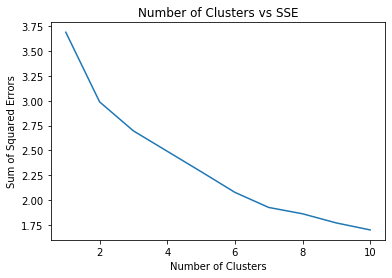

In [18]:
toronto_clustering = toronto_grouped.drop(['PostalCode', 'Borough'], 1)

# run the algorithm for different values of k and store the results in a set
sse = {}  # sum of squared errors
for k in range(1, 11):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=20).fit(toronto_clustering)
    
    sse[k] = kmeans.inertia_  # Inertia: Sum of distances of samples to their closest cluster center
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors")
plt.title("Number of Clusters vs SSE")
plt.show()

From the plot we see that the value of _k_ that appears on the elbow is 4. Now we will run the algorithm with that value of k again.

In [19]:
n_clusters = 4

kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=20).fit(toronto_clustering)

toronto_labels = toronto_grouped[['PostalCode']]
toronto_labels.insert(0, 'ClusterLabel', kmeans.labels_)

toronto_merged = toronto_df.merge(toronto_labels.set_index('PostalCode'), how='inner', on='PostalCode')
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,ClusterLabel
0,M1B,Scarborough,"Rouge, Malvern",43.8113,-79.1930,3
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.7878,-79.1564,3
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.7678,-79.1866,3
3,M1G,Scarborough,Woburn,43.7712,-79.2144,3
4,M1H,Scarborough,Cedarbrae,43.7686,-79.2389,3


Make sure that the number of rows of the merged table still match the number of rows of the table that was used in the k-means algorithm.

In [20]:
print("The number of rows match:", toronto_merged.shape[0] == toronto_grouped.shape[0])

The number of rows match: True


Now let's visualize the clusters on the map.

In [21]:
# create map
map_clusters = folium.Map(location=[43.65, -79.38], zoom_start=10.5)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, p_code, bgh, nbh, cluster in zip(toronto_merged['Latitude'],
                                               toronto_merged['Longitude'],
                                               toronto_merged['PostalCode'], 
                                               toronto_merged['Borough'],
                                               toronto_merged['Neighborhood'],
                                               toronto_merged['ClusterLabel']):
    
    label = folium.Popup(str(p_code) + ', ' + str(bgh) + ', ' + str(nbh) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine the clusters and see what they have in common

First we want to get the venues that appear more frequently in each postal code.

In [22]:
# count the number of venues per postal code
venues_count = toronto_venues.groupby('PostalCode').size().reset_index(name='Count')
toronto_venues = toronto_venues.merge(venues_count.set_index('PostalCode'), how='inner', on='PostalCode')

# count the number of rows per category per postal code
count_by_cat = toronto_venues.groupby(['PostalCode', 'Venue Category']).size().reset_index(name='CountByCategory')
freq_by_cat = toronto_venues.merge(count_by_cat.set_index('PostalCode'), how='inner', on=['PostalCode', 'Venue Category'])

# calculate the frequency of each category
freq_by_cat = freq_by_cat[['PostalCode', 'Venue Category', 'Count', 'CountByCategory']].drop_duplicates()
freq_by_cat['Frequency'] = freq_by_cat['CountByCategory'] / freq_by_cat['Count']
freq_by_cat.sort_values(by=['PostalCode', 'Frequency'], ascending=False, inplace=True)
freq_by_cat['Top Venue Categories'] = freq_by_cat[['PostalCode', 'Venue Category']].groupby('PostalCode').transform(lambda s: ", ".join(s))
freq_by_cat = freq_by_cat[['PostalCode', 'Top Venue Categories']].drop_duplicates().reset_index(drop=True)

Now we have a list of the top categories for each cluster. The next step is to explore the top 5 categories in each neighborhood.

In [23]:
toronto_merged = toronto_merged.merge(freq_by_cat.set_index('PostalCode'), how='inner', on='PostalCode')
top_venues = toronto_merged[['Neighborhood', 'ClusterLabel', 'Top Venue Categories']].sort_values(by='ClusterLabel').reset_index(drop=True)
top_venues.head()

,Neighborhood,ClusterLabel,Top Venue Categories
0,Roselawn,0,"Italian Restaurant, Restaurant, Sushi Restaura..."
1,"Bedford Park, Lawrence Manor East",0,"Bakery, Italian Restaurant, Restaurant, Sandwi..."
2,Humewood-Cedarvale,0,"Italian Restaurant, Pizza Place, Café, Mexican..."
3,Caledonia-Fairbanks,0,"Italian Restaurant, Bakery, Pizza Place, Café,..."
4,Lawrence Park,0,"Bakery, Sushi Restaurant, Café, Italian Restau..."


In [24]:
def GetTopVenues(venues, num_venues):
    venue_lst = venues.split(', ')
    
    if len(venue_lst) < num_venues:
        venue_lst = venue_lst + (['NA'] * (5 - len(venue_lst)))
    
    return venue_lst[0:num_venues]

In [25]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd', 'th']

# create columns according to number of top venues
columns = ['Neighborhood', 'ClusterLabel']
for ind in np.arange(num_top_venues):
    if ind in [0, 1, 2]:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    else:
        columns.append('{}th Most Common Venue'.format(ind+1, indicators[3]))

# create a new table
top_venues_clusters = pd.DataFrame(columns=columns)
top_venues_clusters['Neighborhood'] = top_venues['Neighborhood']
top_venues_clusters['ClusterLabel'] = top_venues['ClusterLabel']

for ind in np.arange(top_venues.shape[0]):
    top_venues_clusters.iloc[ind, 2:] = GetTopVenues(top_venues.iloc[ind, 2], num_top_venues)
    
top_venues_clusters.head()

,Neighborhood,ClusterLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Roselawn,0,Italian Restaurant,Restaurant,Sushi Restaurant,Bakery,Pizza Place
1,"Bedford Park, Lawrence Manor East",0,Bakery,Italian Restaurant,Restaurant,Sandwich Place,Sushi Restaurant
2,Humewood-Cedarvale,0,Italian Restaurant,Pizza Place,Café,Mexican Restaurant,Sushi Restaurant
3,Caledonia-Fairbanks,0,Italian Restaurant,Bakery,Pizza Place,Café,Mexican Restaurant
4,Lawrence Park,0,Bakery,Sushi Restaurant,Café,Italian Restaurant,Fast Food Restaurant


Now we can look at each cluster separately and make conclusions about the venue categories that are more frequent in each cluster.

#### Cluster 0
We see that cafes and Italian restaurants are amongst the most frequent food venues in this cluster. This cluster is right on Downtown Toronto which makes sense, given that the downtown area of big cities now have a lot of cafes. 

In [26]:
top_venues_clusters[top_venues_clusters['ClusterLabel'] == 0]

,Neighborhood,ClusterLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Roselawn,0,Italian Restaurant,Restaurant,Sushi Restaurant,Bakery,Pizza Place
1,"Bedford Park, Lawrence Manor East",0,Bakery,Italian Restaurant,Restaurant,Sandwich Place,Sushi Restaurant
2,Humewood-Cedarvale,0,Italian Restaurant,Pizza Place,Café,Mexican Restaurant,Sushi Restaurant
3,Caledonia-Fairbanks,0,Italian Restaurant,Bakery,Pizza Place,Café,Mexican Restaurant
4,Lawrence Park,0,Bakery,Sushi Restaurant,Café,Italian Restaurant,Fast Food Restaurant
5,Davisville North,0,Italian Restaurant,Sushi Restaurant,Pizza Place,Indian Restaurant,Café
6,North Toronto West,0,Italian Restaurant,Sushi Restaurant,Café,Bakery,Pizza Place
7,Davisville,0,Italian Restaurant,Sushi Restaurant,Café,Restaurant,Bakery
8,"Moore Park, Summerhill East",0,Italian Restaurant,Café,Sushi Restaurant,Thai Restaurant,Indian Restaurant
9,"Forest Hill North, Forest Hill West",0,Italian Restaurant,Sushi Restaurant,Café,Bakery,Restaurant


#### Cluster 1
We can see that there are a lot of pizza places in this cluster. These are areas more sepparated from the downtown area so it makes sense that there would be a lot of pizza places. Furthermore, we can see a big variety of restaurants from different parts of the world. Toronto is a very diverse city and a lot of immigrants live in the surrounding areas of downtown so this is also expected. It is worth noting that a better clustering could be achieved here in order to cluster by the nationality of the food.

In [27]:
top_venues_clusters[top_venues_clusters['ClusterLabel'] == 1]

,Neighborhood,ClusterLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
15,"Ryerson, Garden District",1,Café,Restaurant,Japanese Restaurant,Gastropub,Italian Restaurant
16,"Chinatown, Grange Park, Kensington Market",1,Café,Bakery,Restaurant,Italian Restaurant,Pizza Place
17,"Commerce Court, Victoria Hotel",1,Café,Restaurant,Japanese Restaurant,Italian Restaurant,Gastropub
18,"Harbord, University of Toronto",1,Café,Japanese Restaurant,Restaurant,Sandwich Place,Ramen Restaurant
19,"The Annex, North Midtown, Yorkville",1,Café,Italian Restaurant,Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant
20,East Toronto,1,Greek Restaurant,Café,Pizza Place,Bakery,Restaurant
21,"Design Exchange, Toronto Dominion Centre",1,Café,Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant
22,"Harbourfront East, Toronto Islands, Union Station",1,Café,Pizza Place,Restaurant,Japanese Restaurant,Sushi Restaurant
23,"The Danforth West, Riverdale",1,Greek Restaurant,Café,Bakery,Restaurant,Vietnamese Restaurant
24,Studio District,1,Café,Bakery,Vietnamese Restaurant,Pizza Place,Fast Food Restaurant


#### Cluster 2
It is immidiately obvious that the most frequent places in this cluster are Chinese restaurants. If we look at this [map] (http://neoformix.com/Projects/DotMaps/TorontoVisMin.html) of the distribution of visible minorities in Toronto, we see that the are where this cluster is has a majority of asian people. 

In [28]:
top_venues_clusters[top_venues_clusters['ClusterLabel'] == 2]

,Neighborhood,ClusterLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
47,"Emery, Humberlea",2,Caribbean Restaurant,Asian Restaurant,Vietnamese Restaurant,Latin American Restaurant,Pizza Place
48,Downsview Northwest,2,Pizza Place,Vietnamese Restaurant,Sandwich Place,Caribbean Restaurant,Fried Chicken Joint
49,"Maple Leaf Park, North Park, Upwood Park",2,Vietnamese Restaurant,Pizza Place,Bakery,Chinese Restaurant,Fast Food Restaurant
50,Downsview Central,2,Vietnamese Restaurant,Pizza Place,Sandwich Place,Restaurant,Chinese Restaurant
51,Downsview West,2,Vietnamese Restaurant,Pizza Place,Bakery,Fast Food Restaurant,Fried Chicken Joint


#### Cluster 3
We see that Vietnamese restaurants, as well as pizza places, are very frequent in this cluster.

In [29]:
top_venues_clusters[top_venues_clusters['ClusterLabel'] == 3]

,Neighborhood,ClusterLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
52,"Del Ray, Keelsdale, Mount Dennis, Silverthorn",3,Pizza Place,Bakery,Sandwich Place,Italian Restaurant,Fast Food Restaurant
53,Glencairn,3,Restaurant,Fast Food Restaurant,Sandwich Place,Sushi Restaurant,Bakery
54,Business reply mail Processing Centre969 Eastern,3,Chinese Restaurant,Restaurant,Bakery,Sandwich Place,Pizza Place
55,"Lawrence Heights, Lawrence Manor",3,Restaurant,Fast Food Restaurant,Sandwich Place,Sushi Restaurant,Pizza Place
56,"Alderwood, Long Branch",3,Pizza Place,Restaurant,Fast Food Restaurant,Sandwich Place,Bakery
57,"Kingsway Park South West, Mimico NW, The Queen...",3,Restaurant,Fast Food Restaurant,Sandwich Place,Pizza Place,Burger Joint
58,"Cloverdale, Islington, Martin Grove, Princess ...",3,Pizza Place,Sandwich Place,Sushi Restaurant,Bakery,Restaurant
59,"Bloordale Gardens, Eringate, Markland Wood, Ol...",3,Pizza Place,Sandwich Place,Café,Restaurant,Fish & Chips Shop
60,Weston,3,Pizza Place,Vietnamese Restaurant,Sandwich Place,Bakery,Fried Chicken Joint
61,Westmount,3,Sandwich Place,Pizza Place,Bakery,Restaurant,Middle Eastern Restaurant


## Conclusion
In this assignment, we've used a web scraper to get location data for the city of Toronto from a Wikipedia page. Afterwards, we cleaned the data and used the Foursquare API to get the food venues in a 2km radius of each postal code. Finally, we used a k-means algorithm to cluster the data into four different clusters, plotted it on a map of Toronto using Folium, and analyzed each cluster based on the most common venues.